### PREPARATION

In [1]:
!pip install autokeras
!pip install tensorflow_addons

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import autokeras as ak

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-02 11:08:56.352920: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 11:08:56.397995: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 11:08:56.398033: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 11:08:56.398061: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already b

Using TensorFlow backend


In [3]:
DATA_PATH = "data/cicdata.csv"
LABEL_PATH = "data/ciclabel.csv"

early_warning = pd.read_csv(DATA_PATH)
rotulos = pd.read_csv(LABEL_PATH)

init = 99
train = 560
test = 1484
cols = ["5_kurt_total_ips_origem", 
        "5_skw_total_ips_destino", 
        "5_voefficient_variation_total_pacotes"]

In [4]:
x_train = early_warning[cols][init:train]
y_train = rotulos['maior_2'][init:train]

x_test = early_warning[cols][train:test]
y_test = rotulos['maior_2'][train:test]

x_train = x_train.fillna(-1)
x_test = x_test.fillna(-1)

### LOAD MODEL

In [5]:
from tensorflow.keras.models import load_model
MODEL_PATH = "models/cicmodel"
loaded_model = load_model(MODEL_PATH, custom_objects=ak.CUSTOM_OBJECTS, compile=False)

2023-11-02 11:08:59.061481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 11:08:59.062617: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### RECONSTRUCTION

In [6]:
Xtrain = x_train.values.reshape(x_train.shape[0], 1, x_train.shape[1])
X_pred_train = loaded_model.predict(Xtrain)
X_pred_train = pd.DataFrame(X_pred_train, columns=x_train.columns, index=x_train.index)
X_pred_train.index = x_train.index
X_pred_train

15/15 [==============================] - 3s 5ms/step


,5_kurt_total_ips_origem,5_skw_total_ips_destino,5_voefficient_variation_total_pacotes
99,1.970706,1.442229,2.318881
100,2.058901,1.380591,2.449878
101,2.058901,1.380591,2.449878
102,2.067335,1.373042,2.463308
103,1.977802,1.476136,2.286504
...,...,...,...
555,35.789024,6.417823,10.916689
556,35.771233,6.414857,10.912305
557,35.000881,6.284562,10.719992
558,35.301552,6.335471,10.795095


Text(0.5, 1.0, 'Modelo com novas features')

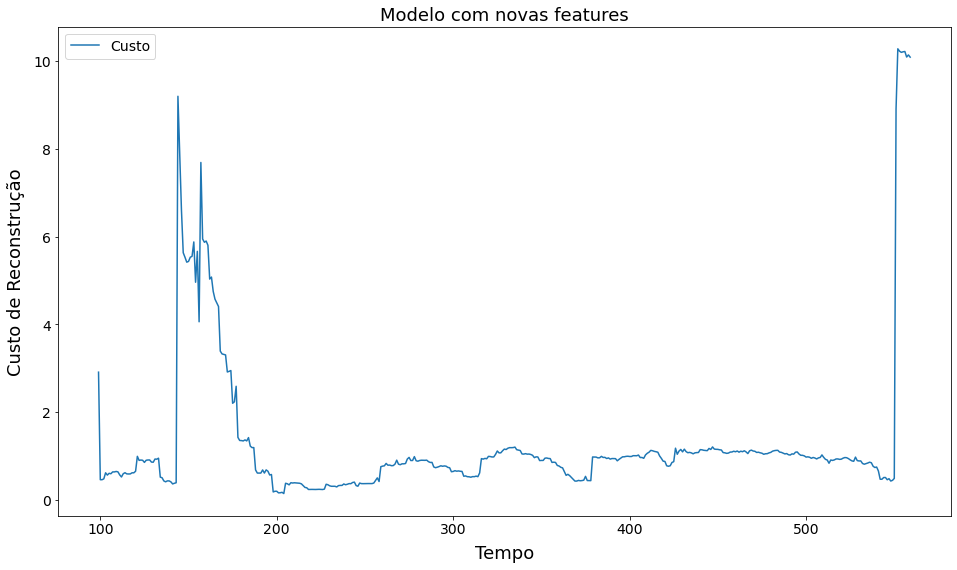

In [7]:
fig, ax = plt.subplots(figsize=(16, 9))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)

ax.plot(np.mean(np.abs(X_pred_train-x_train), axis=1), label='Custo')
plt.xlabel("Tempo", fontsize=18, labelpad=8.0)
plt.ylabel("Custo de Reconstrução", fontsize=18, labelpad=8.0)
leg = ax.legend(prop={"size":14})

plt.title("Modelo com novas features", fontsize=18)

In [8]:
# scored_train = pd.DataFrame()
# scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-x_train), axis = 1)

# plt.figure(figsize=(10,6), dpi=80)
# plt.title('Distribuição do Custo de Reconstrução', fontsize=22)
# sns.distplot(scored_train['Loss_mae'], bins = 50, kde=True, color = 'navy')
# sns.set(font_scale=1.4)
# plt.xlim([0.0,9])
# plt.xlabel("Reconstruction Cost", fontsize=18, labelpad=8.0)
# plt.ylabel("Density", fontsize=18, labelpad=8.0)

### TEST

In [9]:
threshold = 8.3

Xtest = x_test.values.reshape(x_test.shape[0], 1, x_test.shape[1])
X_pred_test = loaded_model.predict(Xtest)
X_pred_test = pd.DataFrame(X_pred_test, columns=x_test.columns)

scored_test = pd.DataFrame()
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[2])
scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test-Xtest), axis = 1)
scored_test['Anomaly'] = scored_test['Loss_mae'] > threshold
scored_test.tail()

concatenated = scored_test.copy()
concatenated.index = y_test.index
concatenated['label'] = y_test
concatenated['label'] = concatenated['label'].astype(int)
concatenated

29/29 [==============================] - 0s 4ms/step


In [10]:
xticklabels=['Normal', 'Anomalia'] 
yticklabels=['Normal', 'Anomalia']
# cm = confusion_matrix(concatenated['label'], concatenated['Anomaly'])
# s = sns.heatmap(cm, annot=True, fmt='d', xticklabels=xticklabels, yticklabels=yticklabels)
# s.set(xlabel='Valor Predito', ylabel='Valor Real', title=f"Threshold {threshold}")

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(confusion_matrix(concatenated["label"], concatenated["Anomaly"]))
print(classification_report(concatenated["label"], concatenated["Anomaly"], digits=4))

[[785  16]
 [117   6]]
              precision    recall  f1-score   support

           0     0.8703    0.9800    0.9219       801
           1     0.2727    0.0488    0.0828       123

    accuracy                         0.8561       924
   macro avg     0.5715    0.5144    0.5023       924
weighted avg     0.7907    0.8561    0.8102       924



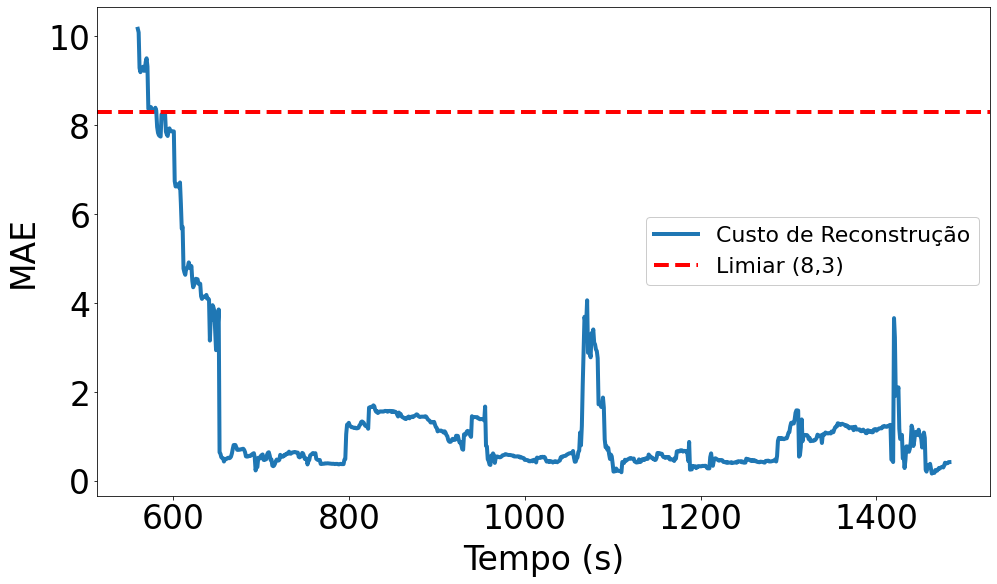

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
#plt.style.use('classic')

fsize = 33

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(fsize)
    
erro = [np.nan] * train
erro.extend(np.mean(np.abs(X_pred_test-Xtest), axis=1))

ax.plot(erro, linewidth=4, label='Custo de Reconstrução')

plt.axhline(y=threshold, linewidth=4,color="r", linestyle="--", label="Limiar (8,3)")

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlabel("Tempo (s)", fontsize=fsize, labelpad=8.0)
plt.ylabel("MAE", fontsize=fsize, labelpad=8.0)
plt.legend(fontsize=fsize-11, loc="center right", framealpha=1)

plt.savefig("custocic.pdf", pad_inches=0, bbox_inches='tight', transparent=True)